In [100]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [84]:

# columns_to_plot = df.iloc[:, :]

# # Loop through each selected column and plot it
# for column in columns_to_plot.columns:
#     if pd.api.types.is_numeric_dtype(columns_to_plot[column]):
#         plt.figure(figsize=(10, 5))  # Set the figure size
#         plt.plot(df.index, columns_to_plot[column], marker='.')  # Plot each column as a line graph
#         plt.title(f'Line Graph for {column}')  # Title with the column name
#         plt.xlabel('Date')  # Label for the x-axis
#         plt.ylabel(column)  # Label for the y-axis
#         plt.grid(True)  # Add a grid for better readability
#         plt.show()  # Display the plot
#     else:
#         print(f"Skipping column {column} as it is not numeric.")

In [85]:
df = pd.read_csv('Data/Data/collective1972-2023.csv')

df['LOCAL_DATE'] = pd.to_datetime(df['LOCAL_DATE'])
# df.set_index('LOCAL_DATE', inplace=True)

# Extract year, month, and day into separate columns
# df['Year'] = df['LOCAL_DATE'].dt.year
df['Month'] = df['LOCAL_DATE'].dt.month
df['Day'] = df['LOCAL_DATE'].dt.day

print(df.head())
# Drop rows where 'Flow0' is NaN
df = df.dropna(subset=['Flow0'])
# Drop rows where CITY is either 'Jasper' or 'Prince George'
df = df[~df['CITY'].isin(['Jasper', 'Prince George'])]

# Labels are the values we want to predict
labels = np.array(df['Flow0'])
# Remove the labels from the df
# axis 1 refers to the columns
df = df.drop(columns=['LOCAL_DATE', 'SYM', 'CITY', 'STATION','LONGITUDE', 'LATITUDE', 'MAX_REL_HUMIDITY', 'MIN_REL_HUMIDITY',
                'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST', 'COOLING_DEGREE_DAYS', 'TOTAL_RAIN', 'TOTAL_SNOW', 'Flow0', 'Flow-1', 'Flow-2', 'Flow-3'])
# Saving feature names for later use
feature_list = list(df.columns)

# Convert to numpy array
df = np.array(df)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(df, labels, test_size = 0.20, random_state = 22)

  LOCAL_DATE       CITY  STATION  LATITUDE  LONGITUDE  DIRECTION_MAX_GUST  \
0 1971-02-08  Mackenzie  1184790   55.3053  -123.1381                 NaN   
1 1971-02-09  Mackenzie  1184790   55.3053  -123.1381                 NaN   
2 1971-02-10  Mackenzie  1184790   55.3053  -123.1381                 NaN   
3 1971-02-11  Mackenzie  1184790   55.3053  -123.1381                 NaN   
4 1971-02-12  Mackenzie  1184790   55.3053  -123.1381                 NaN   

   SPEED_MAX_GUST  COOLING_DEGREE_DAYS  HEATING_DEGREE_DAYS  MAX_REL_HUMIDITY  \
0             NaN                  0.0                 30.5               NaN   
1             NaN                  0.0                 30.5               NaN   
2             NaN                  0.0                 19.4               NaN   
3             NaN                  0.0                 23.0               NaN   
4             NaN                  0.0                 13.5               NaN   

   ...  MAX_TEMPERATURE  MEAN_TEMPERATURE  MIN_TEM

In [86]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (15456, 8)
Training Labels Shape: (15456,)
Testing Features Shape: (3864, 8)
Testing Labels Shape: (3864,)


In [87]:

# Baseline errors, and display average baseline error
baseline_errors = abs(np.mean(labels) - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  580.25


In [88]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 200, random_state = 22)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=200, random_state=22)

In [89]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'cusecs.')

# Flow 0 Day -----------------------------------------------
mse = mean_squared_error(test_labels, predictions)
print(f"Mean Squared Error (Flow +1): {mse}")

r_squared = r2_score(test_labels, predictions)
print(f"R-squared (Flow +1): {r_squared}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (Flow +1): {rmse}")


# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 235.04 cusecs.
Mean Squared Error (Flow +1): 142571.51922074798
R-squared (Flow +1): 0.739128818237277
Root Mean Squared Error (Flow +1): 377.5864394026194
Accuracy: 66.57 %.


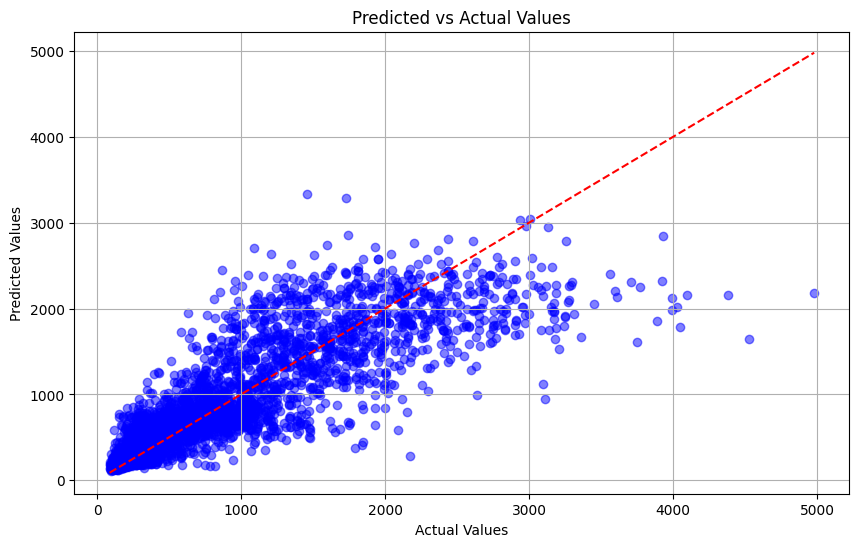

In [90]:
# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, predictions, color='blue', alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], color='red', linestyle='--')  # Diagonal line
plt.grid(True)
plt.show()

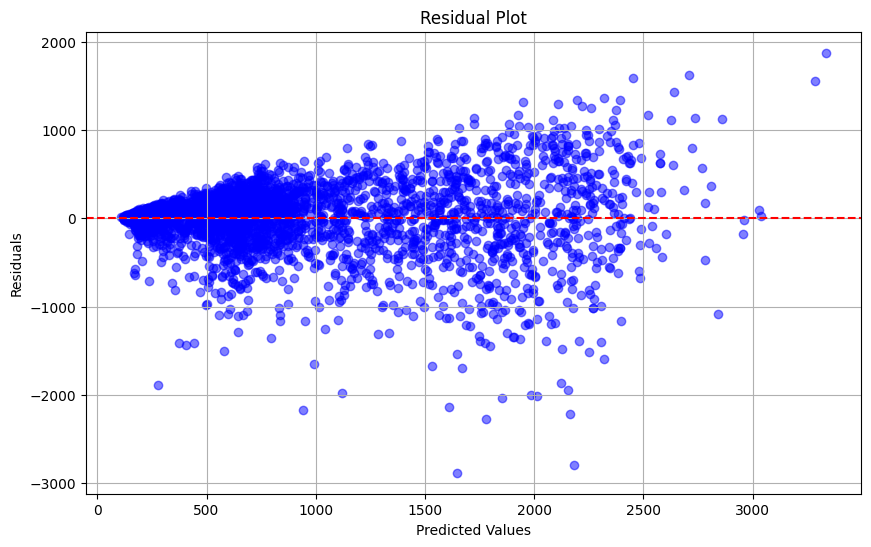

In [91]:
# Calculate residuals
residuals = predictions - test_labels
# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

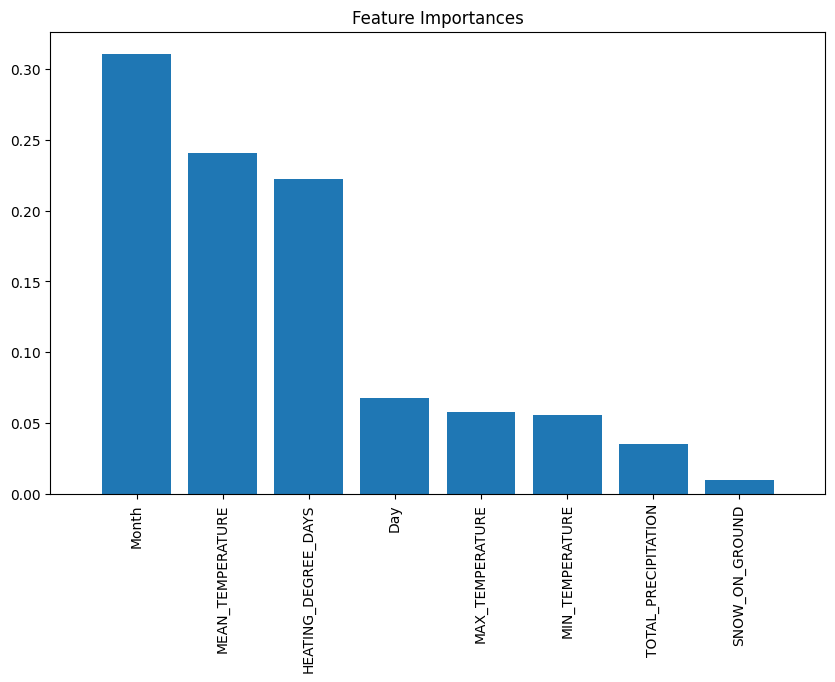

In [92]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(train_features.shape[1]), importances[indices], align='center')
plt.xticks(range(train_features.shape[1]), np.array(feature_list)[indices], rotation=90)
plt.xlim([-1, train_features.shape[1]])
plt.show()

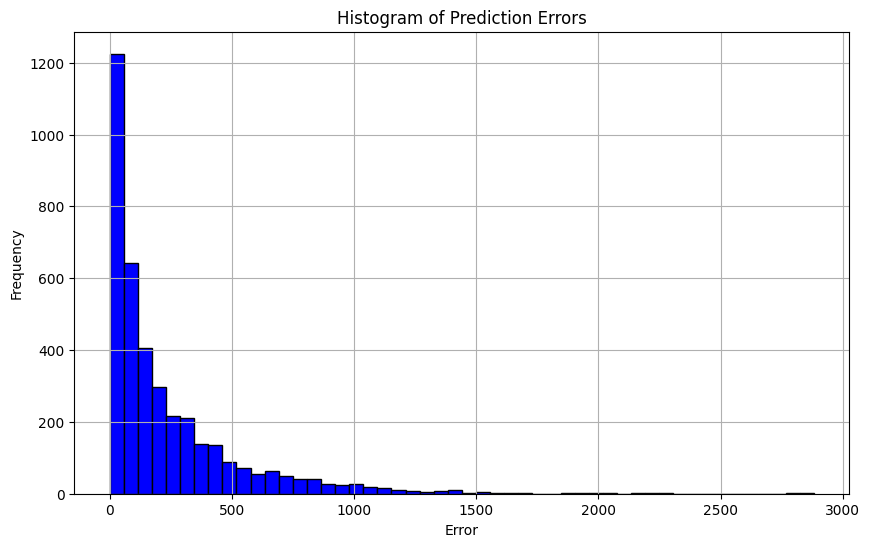

In [93]:
# Histogram of errors
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.grid(True)
plt.show()

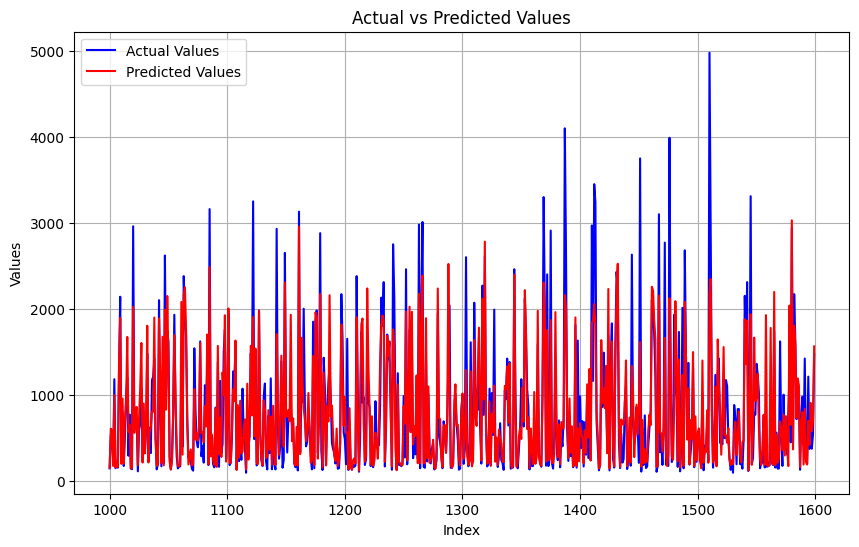

In [94]:
# Define the range of indices you want to plot
start_index = 1000
end_index = 1600

# Ensure indices are within bounds
start_index = max(start_index, 0)
end_index = min(end_index, len(test_labels))

# Slice the arrays
test_labels_subset = test_labels[start_index:end_index]
predictions_subset = predictions[start_index:end_index]

# Line plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(start_index, end_index), test_labels_subset, color='blue', label='Actual Values')
plt.plot(range(start_index, end_index), predictions_subset, color='red', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [95]:
new_data = pd.read_csv('Data/Data/liard1944-2013.csv')  # Replace with the actual path to your new dataset

new_data['LOCAL_DATE'] = pd.to_datetime(new_data['LOCAL_DATE'])

new_data['Month'] = new_data['LOCAL_DATE'].dt.month
new_data['Day'] = new_data['LOCAL_DATE'].dt.day

# Drop rows where 'Flow0' is NaN
new_data = new_data.dropna(subset=['Flow0'])
# Labels are the values we want to predict
labels = np.array(new_data['Flow0'])
# Remove the labels from the new_data
new_data = new_data.drop(columns=['LOCAL_DATE', 'SYM', 'CITY', 'STATION', 'LONGITUDE', 'LATITUDE', 'MAX_REL_HUMIDITY', 'MIN_REL_HUMIDITY',
                'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST', 'COOLING_DEGREE_DAYS', 'TOTAL_RAIN', 'TOTAL_SNOW', 'Flow0', 'Flow-1', 'Flow-2', 'Flow-3'])
# Saving feature names for later use
feature_list = list(new_data.columns)

# Convert to numpy array
new_data = np.array(new_data)

Y_pred2 = rf.predict(new_data)

# Example: Viewing predictions
print(Y_pred2)


# Calculate the absolute errors
errors = abs(Y_pred2 - labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'cusecs.')

# Flow 0 Day -----------------------------------------------
mse = mean_squared_error(labels, Y_pred2)
print(f"Mean Squared Error (Flow +1): {mse}")

r_squared = r2_score(labels, Y_pred2)
print(f"R-squared (Flow +1): {r_squared}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (Flow +1): {rmse}")


# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


[1317.215 1447.195 1396.115 ... 1643.395 1992.2   2118.5  ]
Mean Absolute Error: 493.11 cusecs.
Mean Squared Error (Flow +1): 711554.0404281674
R-squared (Flow +1): 0.5178612157742262
Root Mean Squared Error (Flow +1): 843.5366266073853
Accuracy: 56.27 %.


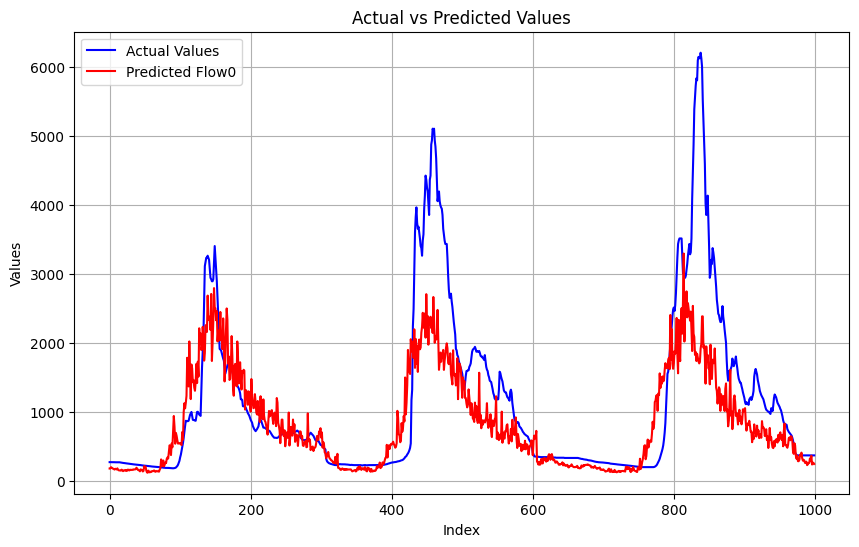

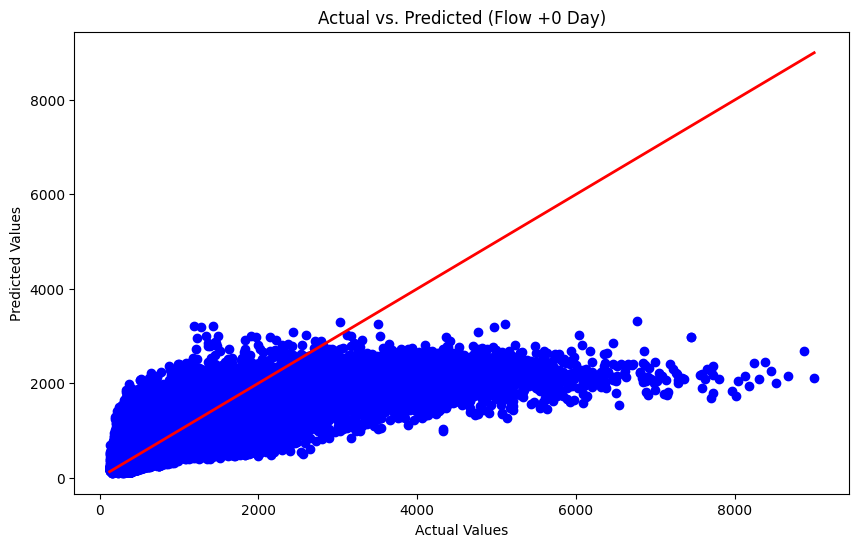

In [96]:


# Define the range of indices you want to plot
start_index = 3600
end_index = 4600


# Ensure indices are within bounds
start_index = max(start_index, 0)
end_index = min(end_index, len(labels))

# Slice the arrays
Y2_subset = labels[start_index:end_index]
Y_pred2_subset = Y_pred2[start_index:end_index]


plt.figure(figsize=(10, 6))
plt.plot(range(len(Y2_subset)), Y2_subset, color='blue', label='Actual Values')
plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset, color='red', label='Predicted Flow0')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


# Scatter plots for each output (Flow+1, Flow+2, Flow+3)
plt.figure(figsize=(10, 6))
plt.scatter(labels, Y_pred2, color='blue')
plt.plot([min(labels), max(labels)], [min(labels), max(labels)], color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs. Predicted (Flow +0 Day)')
plt.show()


In [97]:
# # Import tools needed for visualization
# from sklearn.tree import export_graphviz
# import pydot
# # Pull out one tree from the forest
# tree = rf.estimators_[5]
# # Import tools needed for visualization
# from sklearn.tree import export_graphviz
# import pydot
# # Pull out one tree from the forest
# tree = rf.estimators_[5]
# # Export the image to a dot file
# export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# # Use dot file to create a graph
# (graph, ) = pydot.graph_from_dot_file('tree.dot')
# # Write graph to a png file
# graph.write_png('tree.png')

In [102]:
# # Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png')
print('small_tree.png')

small_tree.png
